# Transformer Model for Neural Machine Translation (NMT)

Machine translation is the task of reading a sentence in one natural language and emitting a sentence with the equivalent meaning in another language. Machine
translation systems often involve many components. At a high level, there is
often one component that proposes many candidate translations. Many of these
translations will not be grammatical due to differences between the languages.

## Importing libraries

In [ ]:
!pip install -q tfds-nightly
!pip install matplotlib==3.2.2

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import time
import numpy as np
import matplotlib.pyplot as plt

## Setting up input pipeline

In [ ]:
data, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)
train_data, val_data = data['train'], data['validation']

In [ ]:
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_data), target_vocab_size=2**13
)

tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_data), target_vocab_size=2**13
)

In [ ]:
sample_string = 'Transformers are amazing!'

tokenized_string = tokenizer_en.encode(sample_string)
print('Tokenized string is: {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print('The string is: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is: [7915, 1248, 7946, 1369, 481, 22, 1527, 7864]
The string is: Transformers are amazing!


In [ ]:
for ts in tokenized_string:
    print('{} ---> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ---> T
1248 ---> ran
7946 ---> s
1369 ---> form
481 ---> ers 
22 ---> are 
1527 ---> amazing
7864 ---> !


In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [ ]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(lang1.numpy()) + [tokenizer_pt.vocab_size+1]
    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(lang2.numpy()) + [tokenizer_en.vocab_size+1]

    return lang1, lang2

In [ ]:
def tf_encode(pt, en):
    result_pt, result_en = tf.py_function(encode, [pt,en], [tf.int64,tf.int64])
    result_pt.set_shape([None])
    result_en.set_shape([None])

    return result_pt, result_en

In [ ]:
MAX_LENGTH = 40

In [ ]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length, tf.size(y) <= max_length)

In [ ]:
train_dataset = train_data.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
train_dataset = train_dataset.cache() # for speeding up the training procedure
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_data.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [ ]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

## Positional Encoding

Since this model has no recurrence or convolutions involved, we cannot determine the relative position of words in the sentences that we are translating.

Positional encodings are like embeddings. The difference just lies in the fact that it also considers the position of the words in a sentence along with their meaning to construct the n dimensional encoding matrix.

In [ ]:
def get_angles(pos, i , d_model):
    angle_rates = 1 / np.power(10000, (2*(i//2)) / np.float32(d_model))
    return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    # applying sin to even indices in the array
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # applying cos to odd indices in the array
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


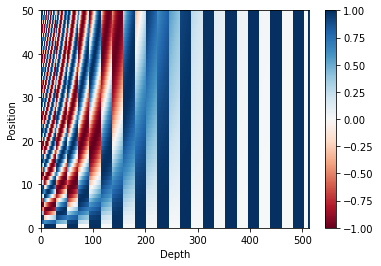

In [ ]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0,512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

Here, we are going to be masking the "pad" tokens and also the future values. The future values are the values which follow the word that we need to translate. That is, if we are to predict the 3rd word, we will be only considering the 2nd and the 1st input. 

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), dtype=tf.float32)

    # adding an extra dimension to store the padding information in the attention logits
    return seq[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)

In [ ]:
x = tf.constant([[4,5,0,0,1], [1,5,4,0,0], [0,0,4,9,0]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 0., 0., 1.]]]], dtype=float32)>

In [ ]:
def create_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask # (seq_len, seq_len)

In [ ]:
x = tf.random.uniform((1,3))
temp = create_lookahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled Dot-Product Attention

In [ ]:
def scaled_dpa(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True) # (..., seq_len_q, seq_len_k)

    # scale matmul qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # adding mask to the scaled tensor
    if mask is not None:
        scaled_attention_logits += (mask * 1e-9)

    # normalizing the softmax on the last axis
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v) # (..., seq_len_q, seq_len_k)

    return output, attention_weights

In [ ]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dpa(q,k,v,None)
    print('Attention weights are: ')
    print(temp_attn)
    print('Output is: ')
    print(temp_out)

In [ ]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

temp_q = tf.constant([[0,10,0]], dtype=tf.float32) # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are: 
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is: 
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [ ]:
temp_q = tf.constant([[0,0,10]], dtype=tf.float32) # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are: 
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is: 
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [ ]:
temp_q = tf.constant([[10,10,0]], dtype=tf.float32) # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are: 
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is: 
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [ ]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are: 
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is: 
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-Head Attention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0,2,1,3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q) # (batch_size, seq_len, d_model)
        k = self.wk(k) # (batch_size, seq_len, d_model)
        v = self.wv(v) # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size) # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size) # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size) # (batch_size, num_heads, seq_len_v, depth)

        scaled_attention, attention_weights = scaled_dpa(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0,2,1,3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)

        return output, attention_weights

In [ ]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1,60,512)) # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point Wise Feed Forward Network

The point wise ffn is a network consisting of fully connected layers with ReLU activation in between.

In [ ]:
def point_wise_ffn(d_model, dff):
    return tf.keras.Sequential([
                                tf.keras.layers.Dense(dff, activation='relu'), # (batch_size, seq_len, dff)
                                tf.keras.layers.Dense(d_model) # (batch_size, seq_len , d_model)
    ])

In [ ]:
sample_ffn = point_wise_ffn(512, 2048)
sample_ffn(tf.random.uniform((64,50,512))).shape

TensorShape([64, 50, 512])

## Encoder and Decoder

The transformer model follows the same general pattern as a standard sequence to sequence with attention model.

-> the input sequence is passed through N encoder layers that generates and output for each word/token in the sequence

-> the decoder attends on the encoder's output and its own input to predict the next word

### Encoder Layer

The encoder layers consists of:

1. Multi-Head Attention
2. Point wise FFN

Each of these sublayers have a residual connection to prevent vanishing gradients, around it followed by a layer normalization.

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_ffn(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attention_output, _ = self.mha(x, x, x, mask) # (batch_size, input_seq_len, d_model)
        attention_output = self.dropout1(attention_output, training=training)
        out1 = self.layernorm1(x + attention_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [ ]:
sample_enc = EncoderLayer(512, 8, 2048)

sample_enc_output = sample_enc(
    tf.random.uniform((64,43,512)), False, None)

sample_enc_output.shape

TensorShape([64, 43, 512])

### Decoder Layer

The decoder layer consists of the following sublayers:

1. Masked Multi-Head Attention (with look ahead and padding mask)
2. Multi-Head Attention (with padding mask) with K and V taken from the encoder output and the Q value taken from the first sub-layer.
3. Point wise FFN.

Again, each suublayer has a residual connection around it and we also apply layer normalization after each sublayer. 

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_ffn(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [ ]:
sample_decoder_layer = DecoderLayer(512, 8 , 2048)

sample_dec_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64,50,512)), sample_enc_output, False, None, None
)

sample_dec_output.shape

TensorShape([64, 50, 512])

### Encoder

The Encoder consists of:

1. Input Embedding
2. Positional Encoding
3. N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is input to the encoder layers whose output in turn is passed to the decoders.

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, max_pos_enc, rate=0.1):
        super(Encoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(max_pos_enc, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        # adding the embedding and the positional encoding
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        
        return x # (batch_size, input_seq_len, d_model)

In [ ]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500, 
                         max_pos_enc=10000)
temp_input = tf.random.uniform((64,62), dtype=tf.int64, minval=0, maxval=200)
sample_enc_output = sample_encoder(temp_input, False, None)
sample_enc_output.shape

TensorShape([64, 62, 512])

### Decoder

The decoder consists of:

1. Output Embeddings
2. Positional Encodings
3. N Decoder Layers

The target is put through an embedding that is summed with the positional encoding. The output of this is fed to the decoder layers whose output in turn is fed to the linear layers for final results.

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, max_pos_enc, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(max_pos_enc, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return x, attention_weights # x.shape = (batch_size, target_seq_len, d_model)

In [ ]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, dff=2048, target_vocab_size=8000, max_pos_enc=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, enc_output=sample_enc_output, training=False, look_ahead_mask=None, padding_mask=None)
output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Transformer

The transformer consists of the encoder, the decoder and the final linear layer to provide the output.

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask) # (batch_size, inp_seq_len, d_model)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output) # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights 

In [ ]:
sample_transformer = Transformer(num_layers=2, d_model=512, num_heads=8, dff=2048, input_vocab_size=8500, target_vocab_size=8000, pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64,38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64,36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, enc_padding_mask=None, look_ahead_mask=None, dec_padding_mask=None)

fn_out.shape # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Setting the Hyperparameters

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

## Custome Learning Rate Scheduler

We are using the Adam optimizer with a custom learning rate scheduler according to the formula found in the paper "Attention is All You Need"

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

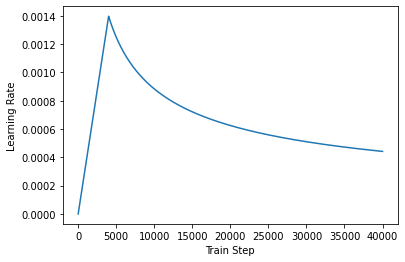

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

## Losses and other Metrics

Since we have padded inputs, while evaluating it is important that we pad the results.

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

## Training and Checkpointing

In [ ]:
transformer = Transformer(num_layers, d_model, num_heads, dff, 
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [ ]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)

    dec_padding_mask = create_padding_mask(inp) # used to mask the encoder output

    look_ahead_mask = create_lookahead_mask(tf.shape(tar)[1]) # used to pad and mask the future tokens
    dec_target_padding_mask = create_padding_mask(tar) # used to pad and mask the future tokens
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# restoring the latest checkpoint if it exists
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Restored Latest Checkpoint!')

Restored Latest Checkpoint!


In [ ]:
EPOCHS = 20

In [ ]:
train_step_signature = [
                        tf.TensorSpec(shape=(None, None), dtype=tf.int64),
                        tf.TensorSpec(shape=(None, None), dtype=tf.int64)
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        preds, _ = transformer(inp, tar_inp, True, enc_padding_mask, combined_mask, dec_padding_mask)
        loss = loss_function(tar_real, preds)
    
    grads = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(grads, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, preds)

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch+1, batch, train_loss.result(), train_accuracy.result()
            ))
    
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(
        epoch+1, train_loss.result(), train_accuracy.result()
    ))

    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

## Evaluating the Model

In [ ]:
def evaluate(inp_sentence):
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]

    # adding starting and ending token since the input statement is Portuguese
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # adding english start token as the target is english
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output
        )

        preds, attention_weights = transformer(
            encoder_input, output, False, enc_padding_mask, combined_mask, dec_padding_mask
        )

        preds = preds[:, -1:, :] # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(preds, axis=-1), tf.int32)

        # return the result if the predicted_id equals the end token
        if predicted_id == tokenizer_en.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights
        
        output = tf.concat([output, predicted_id], axis=-1)
    
    return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16,8))

    sentence = tokenizer_pt.encode(sentence)

    attention = tf.squeeze(attention[layer], axis=0)

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result)-1.5, -0.5)

        ax.set_xticklabels(
            ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'],
            fontdict=fontdict, rotation=90
        )

        ax.set_yticklabels(
            [tokenizer_en.decode([i]) for i in result if i<tokenizer_en.vocab_size], fontdict=fontdict
        )

        ax.set_label('Head {}'.format(head+1))

        plt.tight_layout()
        plt.show()

In [ ]:
def translate(sentence, plot=''):
    result, attn_weights = evaluate(sentence)

    pred_sentence = tokenizer_en.decode([i for i in result if i<tokenizer_en.vocab_size])

    print('Input: {}'.format(sentence))
    print('Predicted Translation: {}'.format(pred_sentence))

    if plot:
        plot_attention_weights(attn_weights, sentence, result, plot)

In [ ]:
translate("este é um problema que temos que resolver.")
print('Real Translation: this is a problem we have to solve')

Input: este é um problema que temos que resolver.
Predicted Translation: clubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclub
Real Translation: this is a problem we have to solve


In [ ]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted Translation: clubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclub
Real translation: and my neighboring homes heard about this idea .


In [ ]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted Translation: clubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclub
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


Input: este é o primeiro livro que eu fiz.
Predicted Translation: clubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclubclub


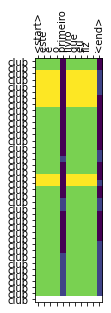

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Real translation: this is the first book i've ever done.


In [ ]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")